In [190]:
#Trazendo os dados de vendas
import pandas as pd

sales = pd.read_csv('bases/data_base.csv')
print(sales)

            date                 datetime cash_type                 card  \
0     2024-03-01  2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   
1     2024-03-01  2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   
2     2024-03-01  2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   
3     2024-03-01  2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   
4     2024-03-01  2024-03-01 13:48:14.626      card  ANON-0000-0000-0004   
...          ...                      ...       ...                  ...   
3631  2025-03-23  2025-03-23 10:34:54.894      card  ANON-0000-0000-1158   
3632  2025-03-23  2025-03-23 14:43:37.362      card  ANON-0000-0000-1315   
3633  2025-03-23  2025-03-23 14:44:16.864      card  ANON-0000-0000-1315   
3634  2025-03-23  2025-03-23 15:47:28.723      card  ANON-0000-0000-1316   
3635  2025-03-23  2025-03-23 18:11:38.635      card  ANON-0000-0000-1275   

      money    coffee_name  
0     38.70          Latte  
1     38.70  Hot Chocolate  


In [191]:
#Filtrando os dados
import warnings
warnings.filterwarnings("ignore")

sales = sales[["date", "coffee_name"]]
sales["date"] = pd.to_datetime(sales["date"])
sales = sales.groupby(sales["date"].dt.to_period('M'))["coffee_name"].count().reset_index(name="qtd")
sales.set_index("date", inplace=True)

display(sales)

,qtd
date,
2024-03,206
2024-04,196
2024-05,267
2024-06,227
2024-07,237
2024-08,272
2024-09,344
2024-10,426
2024-11,259


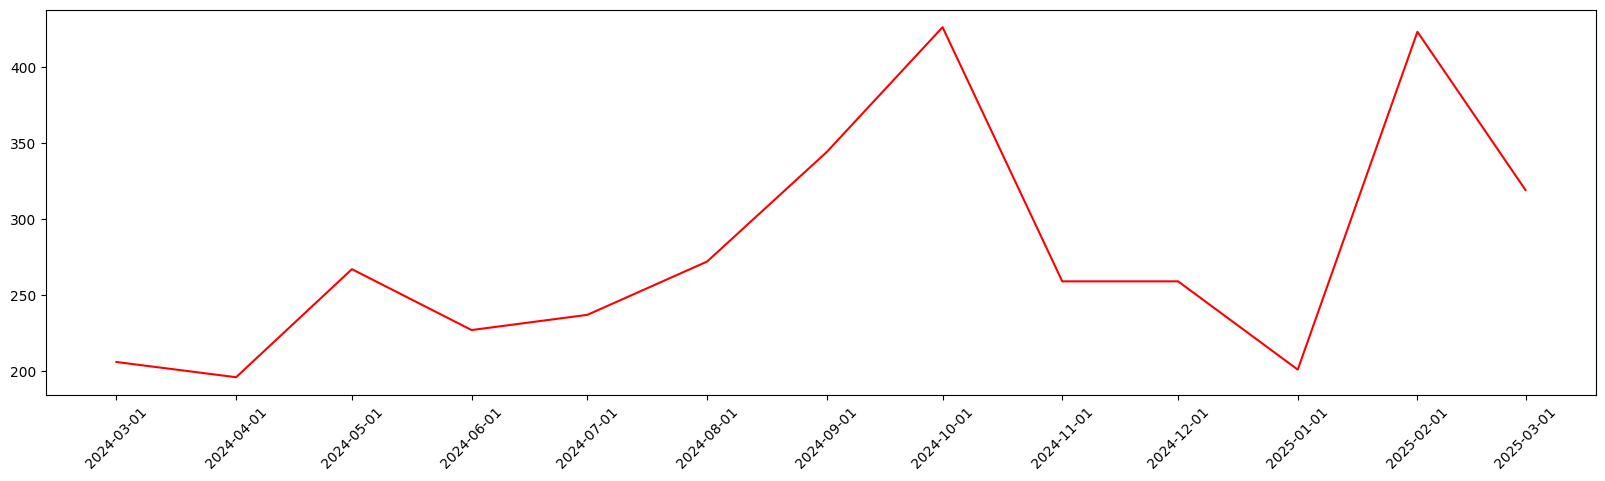

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(sales.index.to_timestamp(), sales.values, color='r', label="Sales")
plt.xticks(sales.index.to_timestamp(), rotation=45)
plt.show()
